# Research Methodology (Week 10)

This week, I just adjusted a few of the plots, tested a few hyperparameters, and increased the number of predictive features 4. I found that the SVM was the best model for predicting DoA with EEG. See the summary for the final results.

In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
from itertools import combinations
from collections import namedtuple
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings

# Experimental Algorithm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Gradient extreme gradient boosted trees
from xgboost import XGBRegressor

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(style="white", palette="pastel")

<br/>

<br/>

# Create Datasets

In [3]:
def create_dataset(data_dir='training', patient=None): 
    """
    Generate training and test sets based on the 17 features selected from week 6. These 
    include all features with a correlation > 0.15 with the BIS.
    
    
    Parameters
    -----------
    data_dir : {"training", "test"}, default = 'training'
        Create the training or test dataset based on the selected features.
        
    patient : String, default=None
        Create the dataset of a patient. It depends on data_dir parameter i.e. if the
        data_dir is set to 'training', then the patient must be present in the training set,
        otherwise, the patient must be present in the test set.
        
        If None, the dataset of the patient is NOT created.
        
        
    Returns
    --------
    dataset: pd.DataFrame
        The training, test, or patient dataset.
    """
    
    folders = ["SampEntropy_CH2Squared", "Katz_CH2Squared", "SampEntropy", "Katz", "SampEntropy_CH2DenoisedSquared", "Katz_CH2DenoisedSquared", "PermEntropy_CH2DenoisedSquared", "Higuchi_CH2DenoisedSquared", "Petrosian_CH2Squared", "Petrosian", "Petrosian_CH2DenoisedSquared"]
    patient_dict = {}
    
    if data_dir == 'training':
        directory = 'Class A train sets'
        
    if data_dir == 'test':
        directory = 'Class B test sets'
        

    for folder in folders:
        if patient == None:
            # Creating the entire dataset using the data.csv files
            df = pd.read_csv("./{}/{}/Modified/data.csv".format(directory, folder))
            
        if patient != None:
            # Creating datasets for each patient
            try:
                df = pd.read_csv("./{}/{}/Modified/{}".format(directory, folder, patient+'_modified.csv'))
                
            except FileNotFoundError:
                print("Patient {} does not exist in the {} set.".format(patient, data_dir))
                return
                

        patient_dict['BIS'] = df['BIS']

        # CH2^2 Folder
        if folder == "Katz_CH2Squared":
            patient_dict['Katz_cA_4'] = df['Katz_cA_4']
            patient_dict['Katz_cD_2'] = df['Katz_cD_2']
            
        if folder == "SampEntropy_CH2Squared":
            patient_dict['SampenCA_4'] = df['SampenCA_4']
            patient_dict['SampenCD_2'] = df['SampenCD_2']


        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian_CH2Squared":
            patient_dict['Petrosian_CA_4'] = df["Petrosian_CA_4"]
            patient_dict['Petrosian_CD_3'] = df["Petrosian_CD_3"]
            
        

        # CH2Denoised Folders
        if folder ==  "SampEntropy":
            patient_dict['SampenCD_2D'] = df['SampenCD_2']
            patient_dict['SampenCA_4D'] = df['SampenCA_4']

        if folder ==  "Katz":
            patient_dict['Katz_cD_2D'] = df['Katz_cD_2']
            patient_dict['Katz_cA_4D'] = df['Katz_cA_4']

        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian":
            patient_dict["Petrosian_CA_4D"] = df["Petrosian_CA_4"]
            patient_dict["Petrosian_CD_3D"] = df["Petrosian_CD_3"]
            patient_dict["Petrosian_CD_1D"] = df["Petrosian_CD_1"]



        # CH2DenoisedSquared Folders
        if folder == "SampEntropy_CH2DenoisedSquared":
            patient_dict['SampenCA_4DS'] = df['SampenCA_4']
            patient_dict['SampenCD_2DS'] = df['SampenCD_2']


        if folder == "Katz_CH2DenoisedSquared":
            patient_dict['Katz_DeltaDS'] = df['Katz_Delta']
            patient_dict['Katz_cD_1DS'] = df['Katz_cD_1']
            patient_dict['Katz_cA_4DS'] = df['Katz_cA_4']
            


        if folder == "PermEntropy_CH2DenoisedSquared":
            patient_dict['Permen_cD_1DS'] = df['Permen_cD_1']
            patient_dict['Permen_cD_3DS'] = df['Permen_cD_3']
            patient_dict['Permen_GammaDS'] = df['Permen_Gamma']


        if folder == "Higuchi_CH2DenoisedSquared":
            patient_dict['Hig_cA_4DS'] = df['Hig_cA_4']


        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian_CH2DenoisedSquared":
            patient_dict["Petrosian_CA_4DS"] = df["Petrosian_CA_4"]
            patient_dict["Petrosian_CD_3DS"] = df["Petrosian_CD_3"]
            patient_dict["Petrosian_CD_1DS"] = df["Petrosian_CD_1"]
            
            
    dataset = pd.DataFrame(patient_dict)
    
    return dataset

<br/>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem;">
    <h1 style="margin: 0; color: #343d52">Model Building</h1>
</div>

In [4]:
training_df = pd.read_csv("training_set.csv")
training_df.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,...,Permen_GammaDS,Hig_cA_4DS,Petrosian_CA_4,Petrosian_CD_3,Petrosian_CA_4D,Petrosian_CD_3D,Petrosian_CD_1D,Petrosian_CA_4DS,Petrosian_CD_3DS,Petrosian_CD_1DS
0,95.8,1.118584,1.589795,2.579210,3.842405,0.295259,0.376660,2.220077,2.975620,0.308904,...,0.993749,1.812455,1.027288,1.035669,1.021992,1.036636,1.030315,1.029542,1.036382,1.030116
1,95.8,1.108791,1.578562,2.427762,3.855503,0.317506,0.404385,2.231705,2.945514,0.319252,...,0.993224,1.812594,1.027169,1.035873,1.022235,1.036839,1.030577,1.029542,1.036585,1.030378
2,95.8,1.111692,1.567324,2.581948,3.533784,0.342623,0.442947,2.239327,2.975240,0.328542,...,0.992231,1.810743,1.026573,1.035720,1.022600,1.036940,1.030892,1.029660,1.036636,1.030672
3,95.6,1.122940,1.594337,2.260806,3.837354,0.371085,0.492027,2.246107,2.976338,0.340638,...,0.991169,1.810351,1.026812,1.035516,1.022357,1.037042,1.031184,1.030014,1.036534,1.030954
4,95.6,1.091586,1.622987,2.301977,3.401760,0.403649,0.552274,2.251073,2.993204,0.337477,...,0.990647,1.808214,1.027050,1.035873,1.022478,1.037143,1.031529,1.030014,1.036788,1.031289


<br/>

## Feature Selection

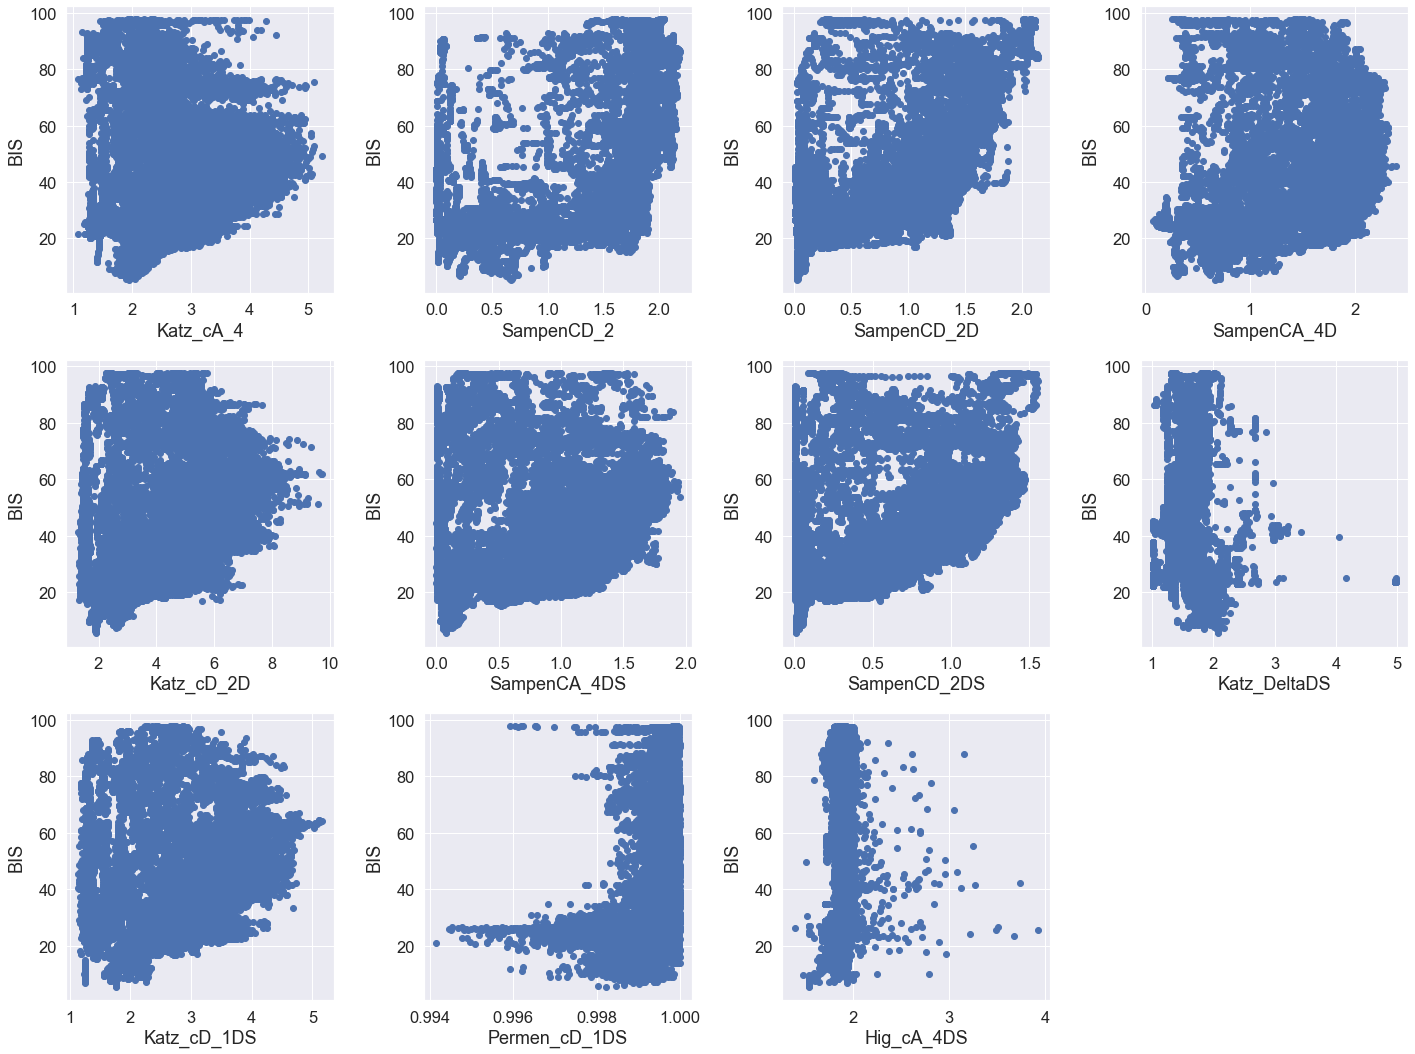

In [23]:
# Selected features
cols = ['Katz_cA_4', 'SampenCD_2', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS']


# Check the relationship between the selected features and the BIS
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax[2, 3].axis('off')

for idx, feature in enumerate(cols[:4]):
    ax[0, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[0, idx].set_ylabel('BIS')
    ax[0, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[4:8]):
    ax[1, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[1, idx].set_ylabel('BIS')
    ax[1, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[8:]):
    ax[2, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[2, idx].set_ylabel('BIS')
    ax[2, idx].set_xlabel(feature)
    
    
plt.tight_layout()
plt.show()

<br/>

## Selected Features

In [15]:
# Adding the petrosian features to the Test B features
selected_features = ['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4DS', 'Katz_cD_1DS', "Petrosian_CA_4", "Petrosian_CD_3", "Petrosian_CA_4D", "Petrosian_CD_3D", "Petrosian_CD_1D", "Petrosian_CA_4DS", "Petrosian_CD_3DS", "Petrosian_CD_1DS"]

<br/>

<br/>

<hr>

# Model Selection and Evaluation

Sebastian discussed how to use *k*-fold cross validation for model selection. So I implemented his ideas. The key idea is keep a separate and independent test set at bay, while we try to model our data with various algorithms. **This is done to avoid the leaking of test data in the training stage**. In addition, I also used GridSearch to find optimum model parameters for each model.

<img src="Model Building.png" />

*Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning* (Sebastian Raschka, 2018)


<b>Model Selection and Evaluation workflow</b>

<br/>

## Model Selection: Part 1

In [10]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale=False, verbose=False):
        self.model = model
        self.data = data
        self.scale = scale        
        self.verbose = verbose
            
            
    # Model Selection
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']
        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            
            
        # Ridge regression
        # Param Grid: [{'alpha': param_range}]
        if self.model == 'lr':
            my_model = LinearRegression()
            my_model.fit(X, y)
            self.my_model = my_model
            
            if self.verbose:
                print("Successfully finished training")
            
            
            
        # Histogram-based Gradient boosting tree (Experimental)
        # Param Grid: [{max_depth: [100, 110, 120, 130, 140]}]
        if self.model == 'hist_r':
            my_model = HistGradientBoostingRegressor(max_depth=100)
            my_model.fit(X, y)
            self.my_model = my_model
            
            if self.verbose:
                print("Successfully finished training")
            

        
        # Extreme Gradient boosted trees
        # Param Grid: [{'n_estimators': [1000, 1500, 2000], 
        #               'max_depth': [7, 8, 9, 10], 
        #               'gamma': [0, 1, 2, 3, 4, 5]}]
        if self.model == "xgboost":
            my_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1)
            my_model.fit(X, y)
            self.my_model = my_model
            
            if self.verbose:
                # Feature imporatance
                print("Feature importances: ", my_model.feature_importances_)
                print("Successfully finished training")
                
                
                
        if self.model == "ransac":
            my_model = RANSACRegressor(LinearRegression(), max_trials=150, min_samples=1000, loss='absolute_loss', residual_threshold=5.0, random_state=0)
            my_model.fit(X, y)
            self.my_model = my_model
            
            if self.verbose:
                print("Successfully finished training")
                
                
        
        if self.model == "svr":
            my_model = SVR(kernel='rbf', degree=4, gamma='auto', C=10.0)
            my_model.fit(X, y)
            self.my_model = my_model
            
            if self.verbose:
                print("Successfully finished training")
                
            

          #-----------------------------------
          # SUMMING MODELS: Future Experiment
          # --------------- -----------------
#         if self.model == "beta":
#             model_a = HistGradientBoostingRegressor(max_depth=10)
#             model_b = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.1)
#             model_a.fit(X,y)
#             model_b.fit(X,y)
            
#             self.model_a = model_a
#             self.model_b = model_b




        

            
    # Predict for training or test set
    def predict(self, test_data, features, visualize_scatter=False, visualize_line=False, show_residual=False, save=False):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']
        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
        
        # Metrics
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        
#         print("Correlation: \n\n", np.corrcoef(y, y_pred))
        
        
        
        
          #-----------------------------------
          # SUMMING MODELS: Future Experiment
          # --------------- -----------------
        
#         if self.model == "beta":
#             y_pred1 = self.model_a.predict(X)
#             y_pred2 = self.model_b.predict(X)
            
#             y_mean = 0.5* (y_pred1 + y_pred2)
            
            
            
#             figure = plt.figure(figsize=(15, 10))
#             plt.plot(y, label="Actual BIS")
#             plt.plot(y_mean, label="Predicted BIS")
#             plt.xlabel('Samples')
#             plt.ylabel('BIS')
#             plt.legend(loc='upper left')
#             plt.title("Depth of Anaesthesia assessment with EEG")
#             plt.show()
            
#             # print the r2 score
#             print("R^2: ", r2_score(y_mean, y))
            
        if save == True:
            saved_predictions = pd.concat([pd.DataFrame({"Actual BIS": y}), pd.DataFrame({"Predicted BIS": y_pred})], axis=1)
            saved_predictions.to_csv("Saved Predictions.csv")

        
        # Visualize after predicting    
        if visualize_line == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, c='lightsteelblue', label="Actual BIS")
            plt.plot(y_pred, c='royalblue', label="Predicted BIS")
            plt.xlabel('Samples')
            plt.ylabel('BIS')
            plt.legend(loc='upper left')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        # scatterplots
        if visualize_scatter == True:
            
            figure = plt.figure(figsize=(15, 10))
            
            # Plot the regression line
            sub_lr = LinearRegression().fit(y[:, np.newaxis], y_pred)
            predictions = sub_lr.predict(y[:, np.newaxis])
            plt.plot(y, predictions, c='red', label='Fitted curve')
            

            
            # Plot the Actual and Predicted BIS
            plt.scatter(y, y_pred, c='royalblue', label='Data')
            
            # Calculate the upper and lower limits to determine outliers
            std = np.std(predictions)
            upper_limit = predictions + 3*std
            lower_limit = predictions - 3*std
            
            # plot the limits
            plt.plot(y, upper_limit, c="k")
            plt.plot(y, lower_limit, c="k")
            
            
            plt.xlabel("Actual BIS")
            plt.ylabel("Predicted BIS")
            plt.legend(loc="upper left")
            plt.title("Depth of Anaesthesia with EEG")
            plt.show()
            
            
            
        if show_residual == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.scatter(y_pred, y_pred - y, c='royalblue', marker='o',  edgecolor='white')
            plt.ylabel("Residuals")
            plt.xlabel("Predicted Values")
            plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black', lw=2)
            plt.xlim([xmin, xmax])
            plt.show()
            
            
        Metrics = namedtuple("Metrics", ["r2", "mse"])
            
        # return the coefficient of determination
        return Metrics(r2, mse)
            
            

In [34]:
# Training a linear regression model on the alpha dataset
test_model = model('svr', training_df, scale=False, verbose=True)

test_model.fit(test_features_B)

Successfully finished training


Show me: 0.7308820995764236


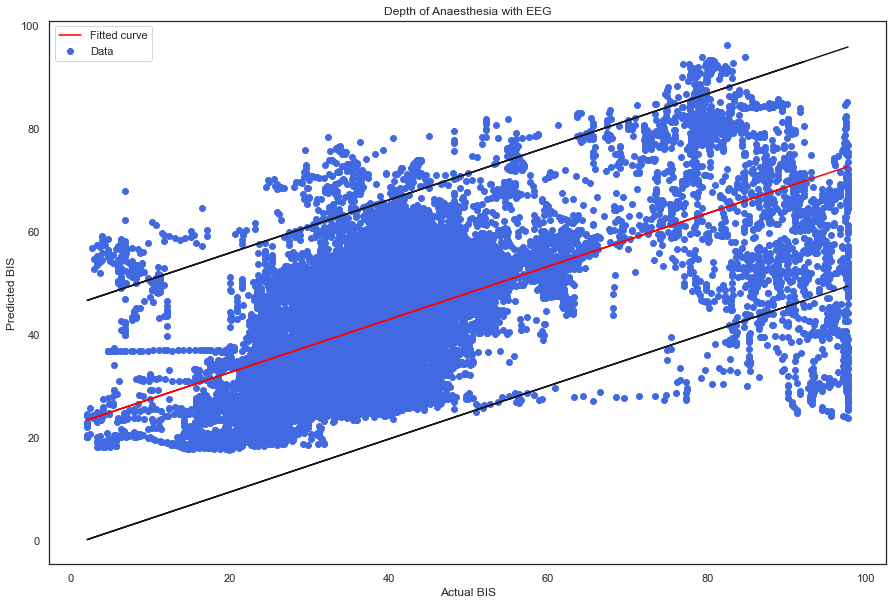

Metrics(r2=0.2555455382100157, mse=168.16365752580583)

In [35]:
# Testing on the original training set
test_model.predict(test_df, test_features_B, visualize_scatter=True, save=True) # returns the r2 score

In [30]:
data = pd.read_csv("Saved Predictions.csv")

In [32]:
r2_score(data["Actual BIS"], data["Predicted BIS"])

0.2555455382100157

<br/>

In [18]:
# Training set (The patients)
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

<br/>

# Coming up with the best features

Dr Li suggested that I find the top 5 feature-sets recommended to predict DoA using EEG using a linear regression model. However, I tried other models for exploratory purposes.

In [19]:
def get_features(model_type, number_of_features=3):

    """Find the features that produce the best R^2 among the patients. 


    Parameters
    ----------
    model_type: model 
        The chosen machine learning model 

    number_of_features: int 
        The number of features preferred.

    Notes
    ------
    The idea here is to model the EEG data using specific featuresets and find the featureset that produces the best metric (coefficient of determination).
    Nonetheless the featureset may produce the best metric in one patient, it may not necessarily produce the best metrics in the other patients. However, it's 
    a good place to start to reduce the number of features. 

    The function also uses the global selected_features list, the training_set list, and the training_df dataframe.

    """
    # Selecting features with Linear regression
    results = {}
    
    # Top 5 feature sets
    feature_set = []

    print("Finding the best combinations... ")

    for combination in combinations(selected_features, number_of_features):

        # r^2 scores for each patient
        patient_scores = []

        # Train a model
        md = model(model_type, training_df, scale=False)
        md.fit(list(combination))

        # Dummy loading
        print("#", end="")

        # Perform resubstitution
        # Here, I'm finding the featureset that gives me the maximum r2 amongst the patients.
        for train in training_set:
            patient = create_dataset(patient=train)
            r2 = md.predict(patient, list(combination))
            patient_scores.append(r2)


        # Store the max score the model achieved
        results[combination] = max(patient_scores)

    print()
    print("All done!")


    new_result = {}
    for key, value in results.items():
        new_result[value] = key

    # sort the values
    sorted_scores = sorted(results.values(), reverse=True)[:5]


    for idx in range(len(sorted_scores)):
        print("{} => {}".format(new_result[sorted_scores[idx]], sorted_scores[idx]))
        feature_set.append(new_result[sorted_scores[idx]])
        
        
    return feature_set
        
        

<br/>

## <code>Linear Regression</code>

In [20]:
lr_features = get_features('lr', number_of_features=3)

Finding the best combinations... 
############################################################################################################################################################################################################################
All done!
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS') => Metrics(r2=0.9125925345948904, mse=57.35200018332762)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1D') => Metrics(r2=0.9103540875462794, mse=58.8207467594616)
('SampenCD_2D', 'Petrosian_CD_3', 'Petrosian_CD_1DS') => Metrics(r2=0.9058940208158722, mse=61.747198713587416)
('SampenCD_2D', 'Petrosian_CD_3', 'Petrosian_CD_3D') => Metrics(r2=0.9009099414708891, mse=65.01747909733234)
('SampenCD_2D', 'Petrosian_CA_4', 'Petrosian_CD_3') => Metrics(r2=0.8989481365397477, mse=66.30470824016359)


<br/>

Feature set:  ('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS')


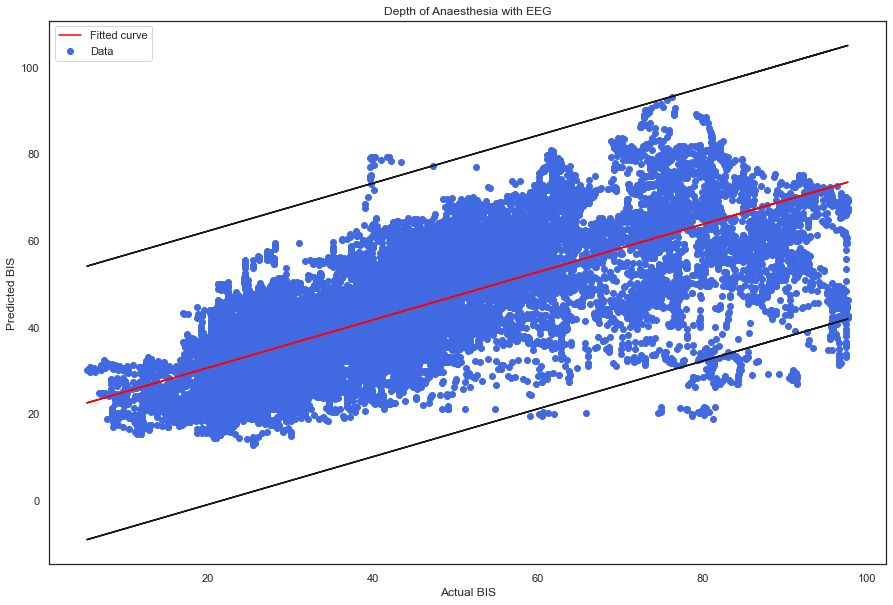

Metrics(r2=0.5513292927676156, mse=163.38366774473593)


Feature set:  ('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1D')


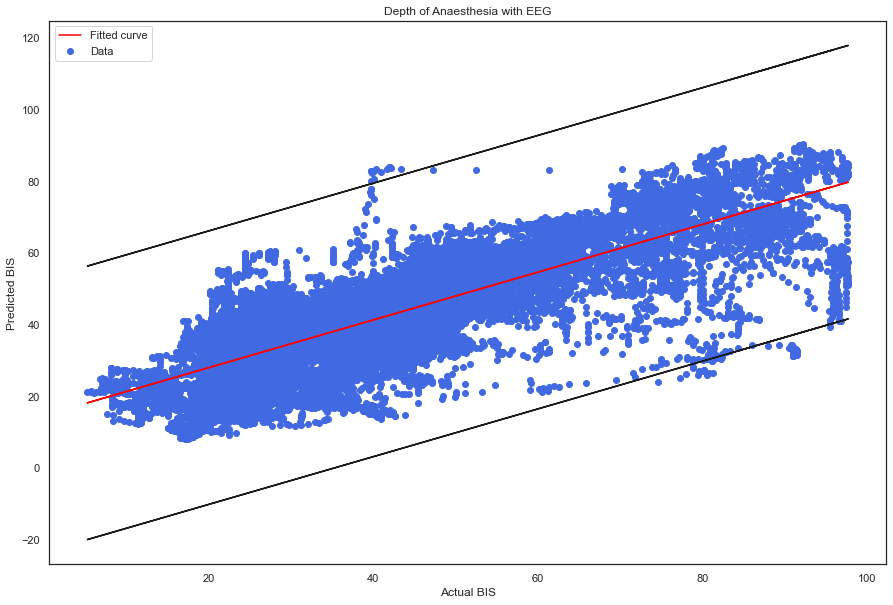

Metrics(r2=0.6671367490617048, mse=121.21232324526868)


Feature set:  ('SampenCD_2D', 'Petrosian_CD_3', 'Petrosian_CD_1DS')


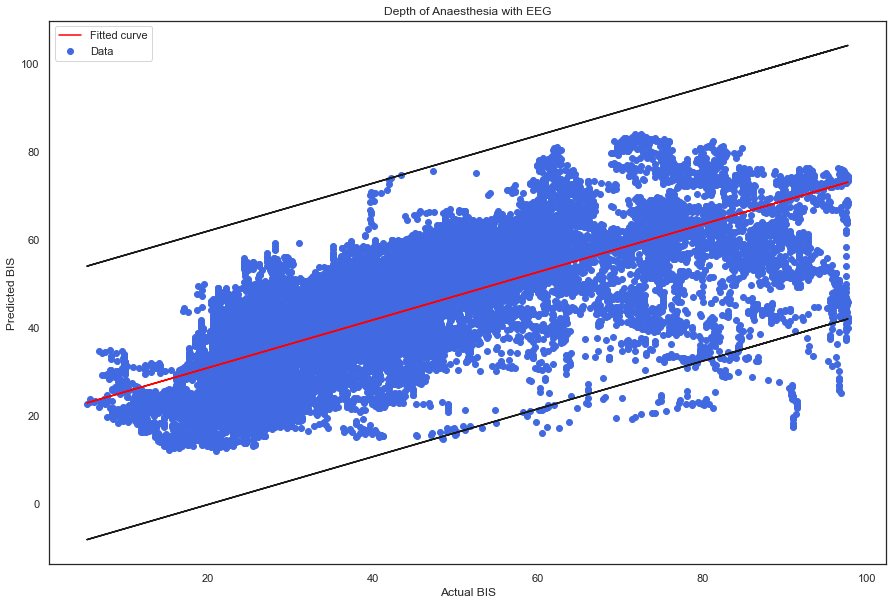

Metrics(r2=0.5420300402277396, mse=166.7699953180726)


Feature set:  ('SampenCD_2D', 'Petrosian_CD_3', 'Petrosian_CD_3D')


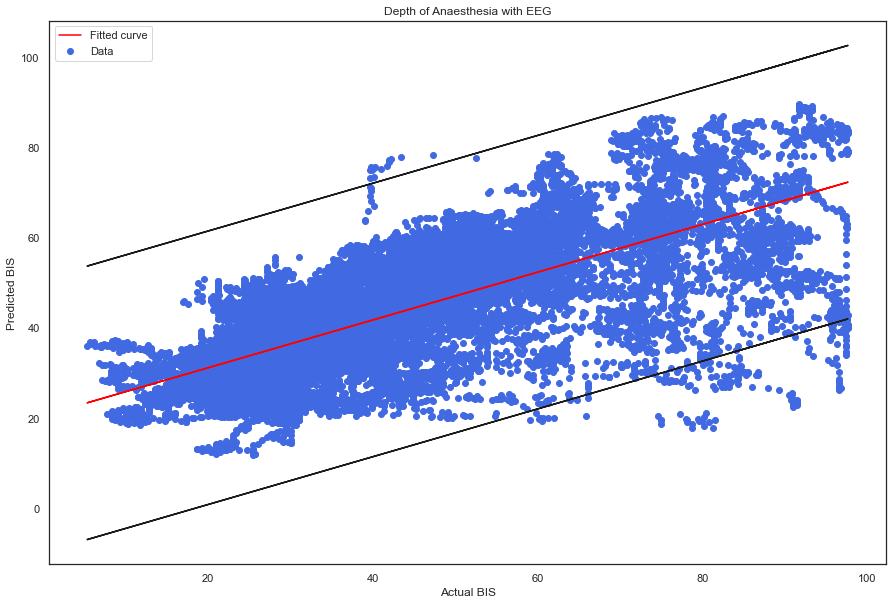

Metrics(r2=0.5294062348802684, mse=171.3669604983673)


Feature set:  ('SampenCD_2D', 'Petrosian_CA_4', 'Petrosian_CD_3')


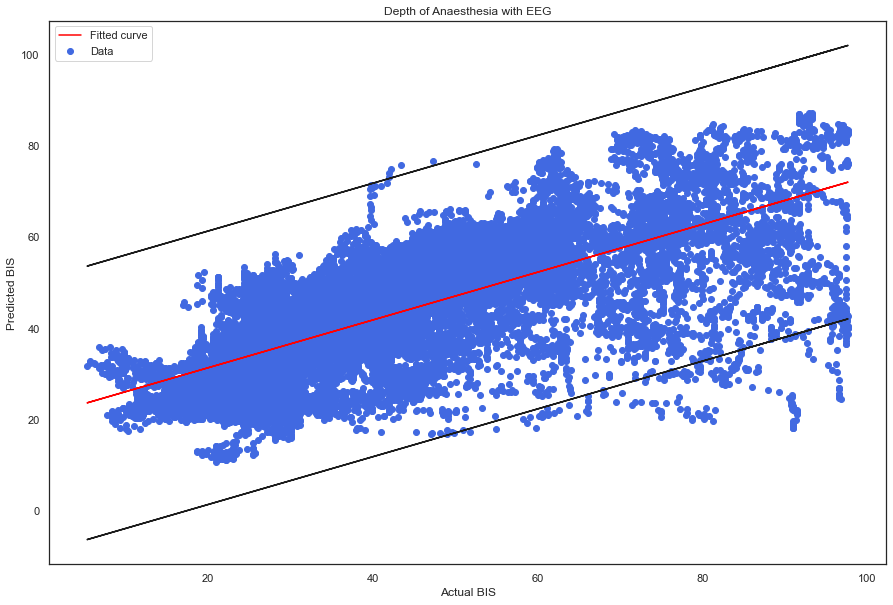

Metrics(r2=0.5235848706652857, mse=173.48681325761862)




In [21]:
for feature_set in lr_features:
    
    print("Feature set: ", feature_set)
    
    lr = model('lr', training_df)
    
    # train the model
    lr.fit(list(feature_set))
    
    # check the training accuracy
    metrics = lr.predict(training_df, list(feature_set), visualize_scatter=True)
    
    print(metrics)
    print()
    print()

<br/>

<br/>

## <code>Histogram regression</code>

In [22]:
hist_features = get_features('hist_r', number_of_features=3)

Finding the best combinations... 
############################################################################################################################################################################################################################
All done!
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3') => Metrics(r2=0.9757412100753661, mse=15.917291706797167)
('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3D') => Metrics(r2=0.9696428133370135, mse=19.9187262437098)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1D') => Metrics(r2=0.9665662055540412, mse=21.937428071010974)
('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3') => Metrics(r2=0.9664354820876866, mse=22.02320166290708)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS') => Metrics(r2=0.9660798792450593, mse=22.25652880723081)


<br/>

Feature set:  ('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3')


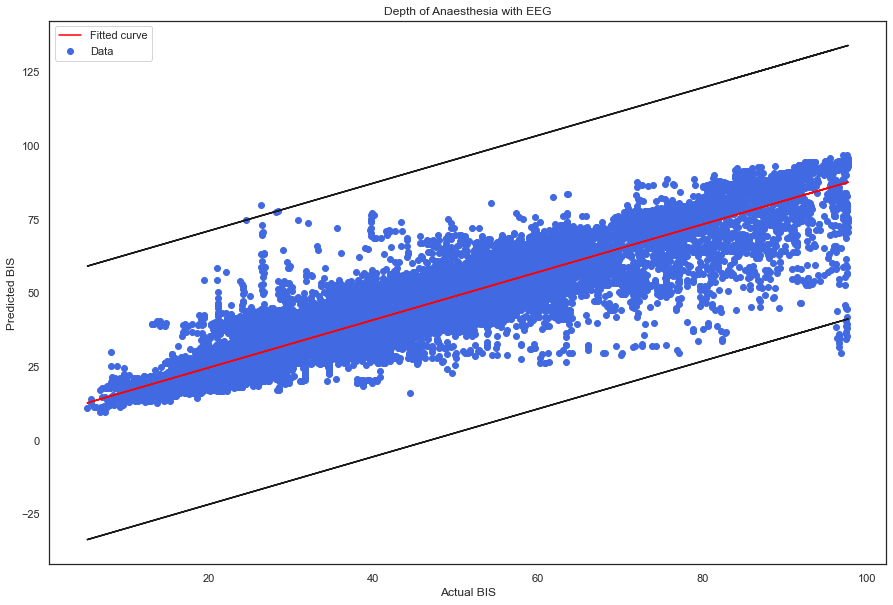

Metrics(r2=0.8473797268043111, mse=55.576750621252586)


Feature set:  ('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3D')


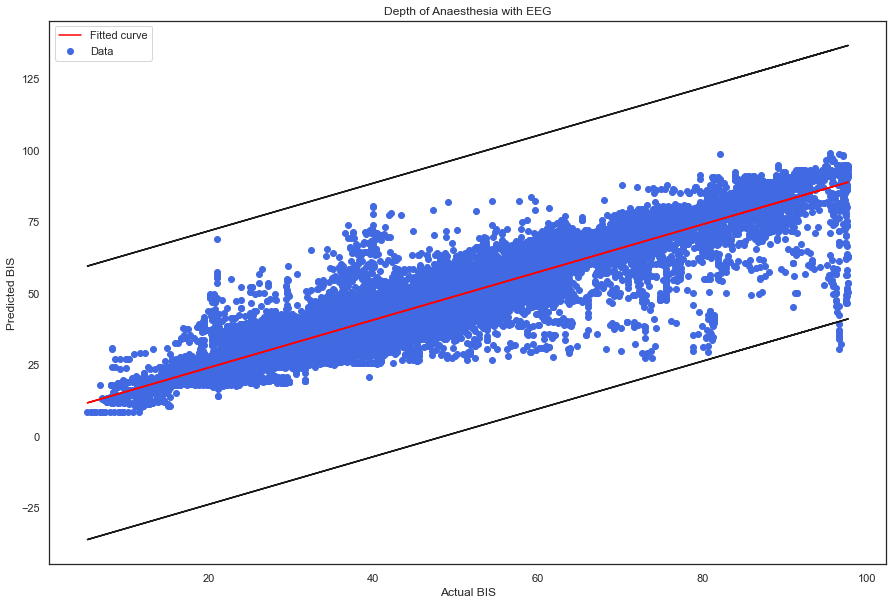

Metrics(r2=0.865825614442452, mse=48.85967119407753)


Feature set:  ('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1D')


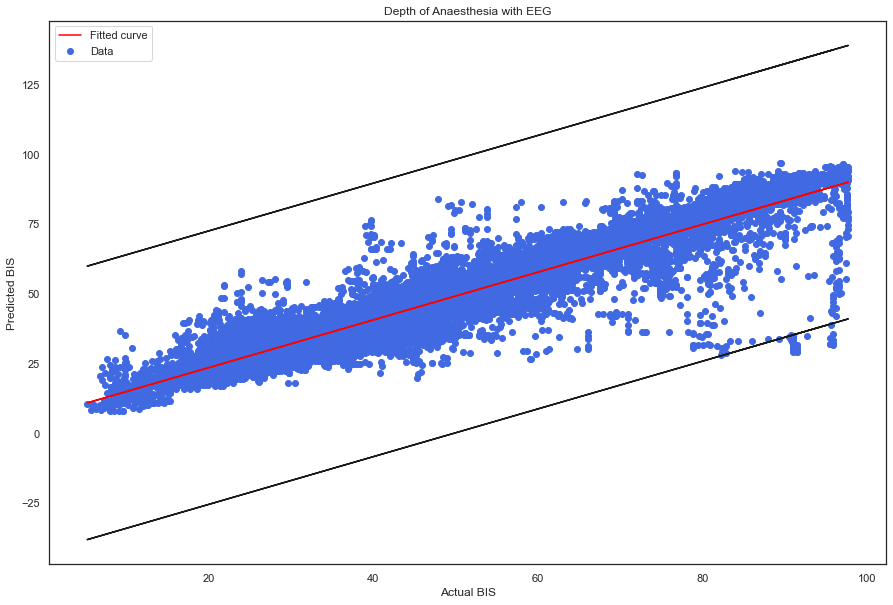

Metrics(r2=0.8808066457463714, mse=43.40432097491265)


Feature set:  ('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3')


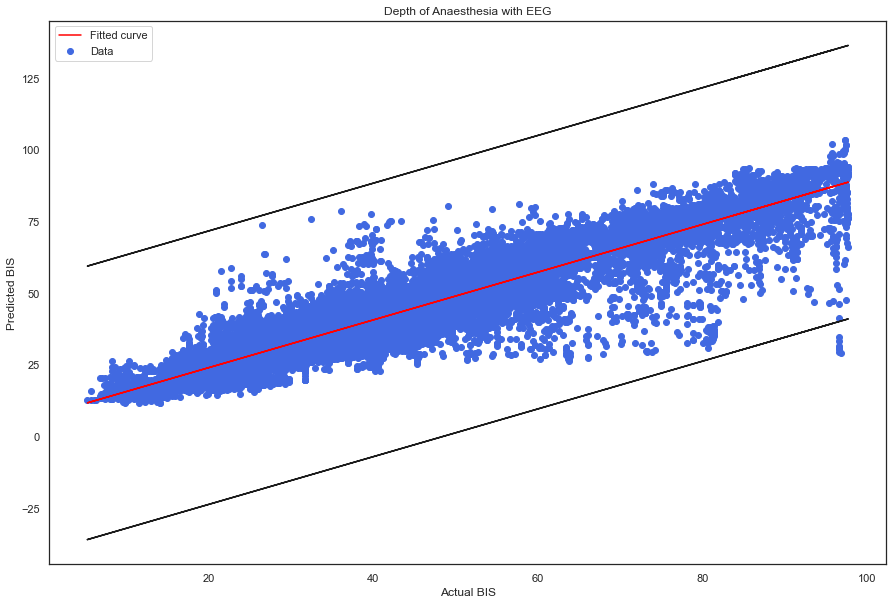

Metrics(r2=0.8618510376155286, mse=50.30701538046684)


Feature set:  ('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS')


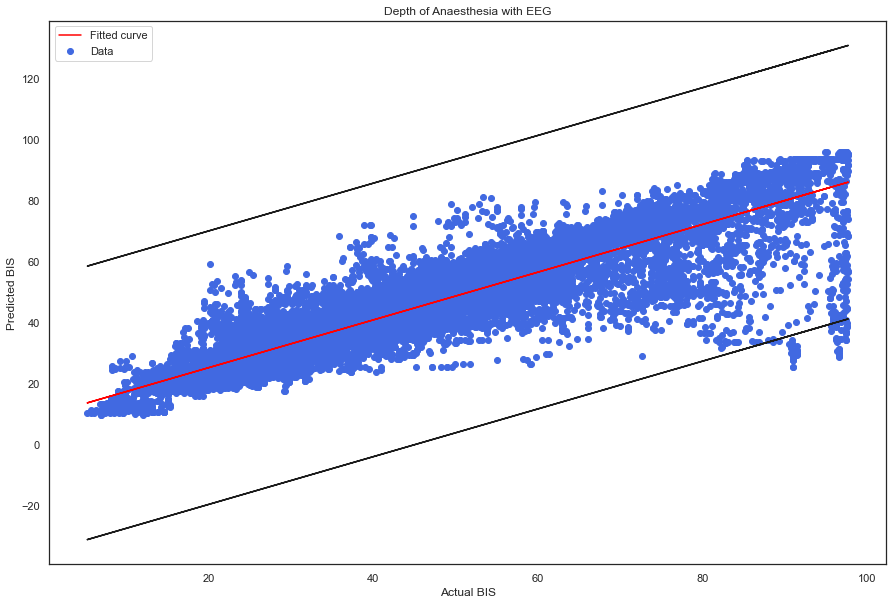

Metrics(r2=0.8167934386072502, mse=66.71476312748253)




In [23]:
for feature_set in hist_features:
    
    print("Feature set: ", feature_set)
    
    hist = model('hist_r', training_df)
    
    # train the model
    hist.fit(list(feature_set))
    
    # check the training accuracy
    metrics = hist.predict(training_df, list(feature_set), visualize_scatter=True)
    
    print(metrics)
    print()
    print()

<br/>

<br/>

## <code>Extreme gradient boosting</code>

In [24]:
xgb_features = get_features('xgboost', number_of_features=3)

Finding the best combinations... 
############################################################################################################################################################################################################################
All done!
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3D') => Metrics(r2=0.9920393018803184, mse=5.223374890272309)
('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3D') => Metrics(r2=0.9903684905826299, mse=6.319669919618129)
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3DS') => Metrics(r2=0.9898297396360334, mse=6.6731688369561715)
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3') => Metrics(r2=0.9896247163534587, mse=6.8076939062429975)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS') => Metrics(r2=0.9893951345906269, mse=6.958332907648642)


<br/>

Feature set:  ('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3D')


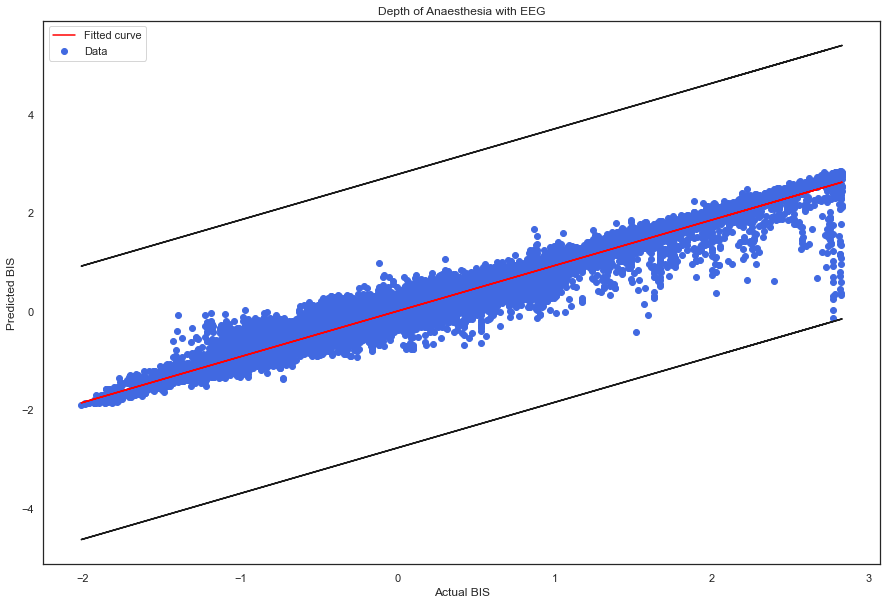

Metrics(r2=0.9584146655925186, mse=0.04158533440748138)


Feature set:  ('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3D')


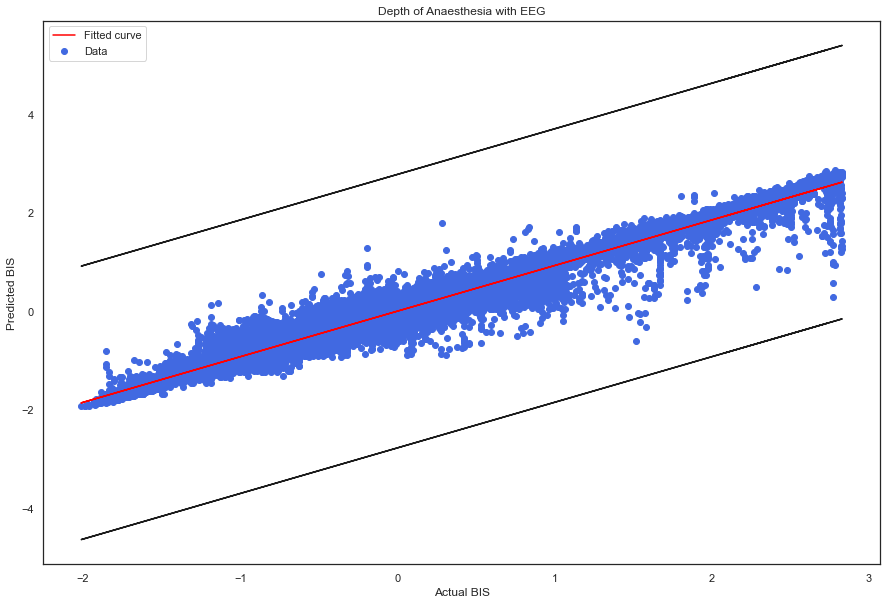

Metrics(r2=0.9549787615747349, mse=0.045021238425265085)


Feature set:  ('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3DS')


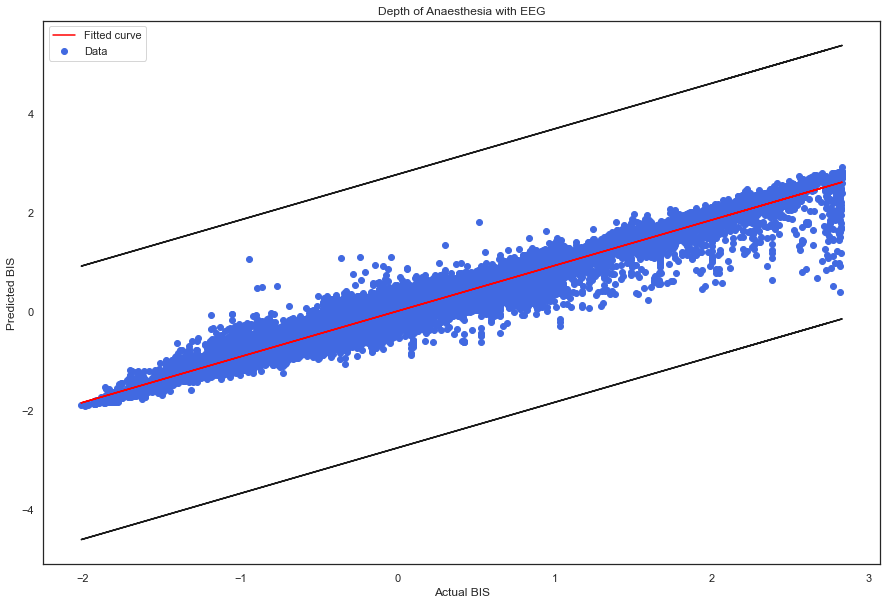

Metrics(r2=0.9559515723402514, mse=0.044048427659748625)


Feature set:  ('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3')


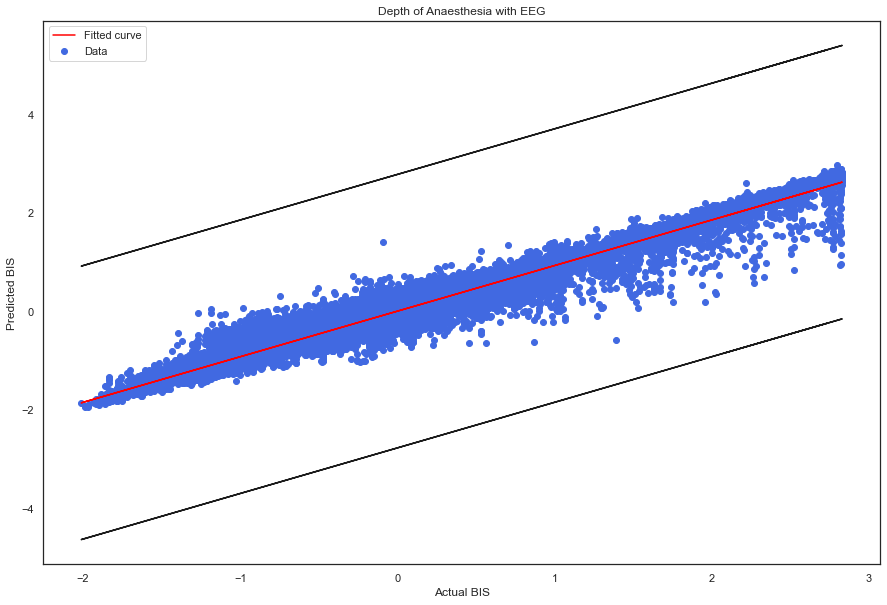

Metrics(r2=0.9594931629267941, mse=0.0405068370732059)


Feature set:  ('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS')


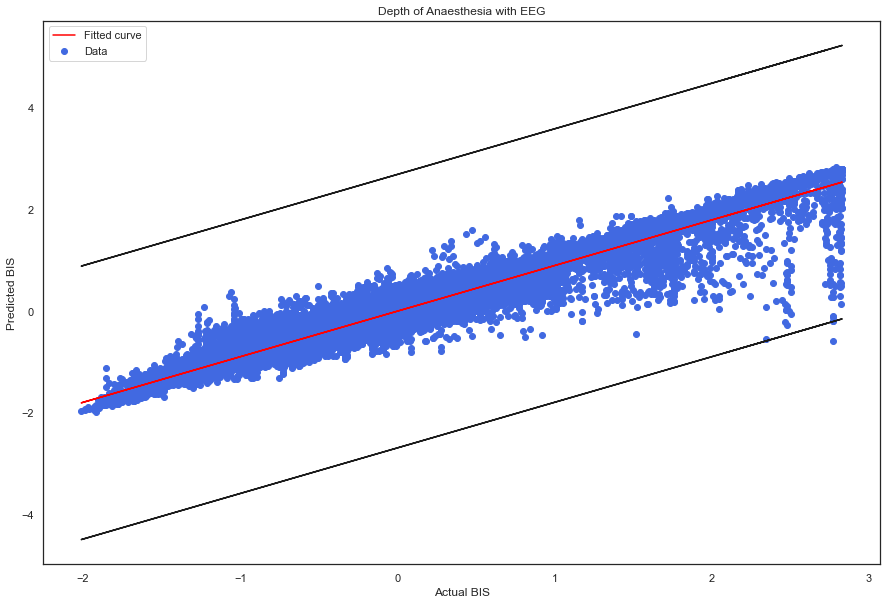

Metrics(r2=0.935144809292651, mse=0.06485519070734903)




In [25]:
for feature_set in xgb_features:
    
    print("Feature set: ", feature_set)
    
    xgb = model('xgboost', training_df, scale=True)
    
    # train the model
    xgb.fit(list(feature_set))
    
    # check the training accuracy
    metrics = xgb.predict(training_df, list(feature_set), visualize_scatter=True)
    
    print(metrics)
    print()
    print()

<br/>

<br/>

```python
# Linear Regression best features
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS') => Metrics(r2=0.9125925345948904, mse=57.35200018332762)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1D') => Metrics(r2=0.9103540875462794, mse=58.8207467594616)
('SampenCD_2D', 'Petrosian_CD_3', 'Petrosian_CD_1DS') => Metrics(r2=0.9058940208158722, mse=61.747198713587416)
('SampenCD_2D', 'Petrosian_CD_3', 'Petrosian_CD_3D') => Metrics(r2=0.9009099414708891, mse=65.01747909733234)
('SampenCD_2D', 'Petrosian_CA_4', 'Petrosian_CD_3') => Metrics(r2=0.8989481365397477, mse=66.30470824016359)


# Histogram boosting best features
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3') => Metrics(r2=0.9757412100753661, mse=15.917291706797167)
('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3D') => Metrics(r2=0.9696428133370135, mse=19.9187262437098)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1D') => Metrics(r2=0.9665662055540412, mse=21.937428071010974)
('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3') => Metrics(r2=0.9664354820876866, mse=22.02320166290708)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS') => Metrics(r2=0.9660798792450593, mse=22.25652880723081)


# Extreme gradient boosted trees best features
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3D') => Metrics(r2=0.9920393018803184, mse=5.223374890272309)
('SampenCD_2D', 'SampenCA_4DS', 'Petrosian_CD_3D') => Metrics(r2=0.9903684905826299, mse=6.319669919618129)
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3DS') => Metrics(r2=0.9898297396360334, mse=6.6731688369561715)
('SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3') => Metrics(r2=0.9896247163534587, mse=6.8076939062429975)
('SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS') => Metrics(r2=0.9893951345906269, mse=6.958332907648642)

```

<br/>

<br/>

In [26]:
## Potential features
test_features_A = ['SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3']
test_features_B = ['SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS']

<br/>

## Training performance: <code>RANSAC Regressor</code>

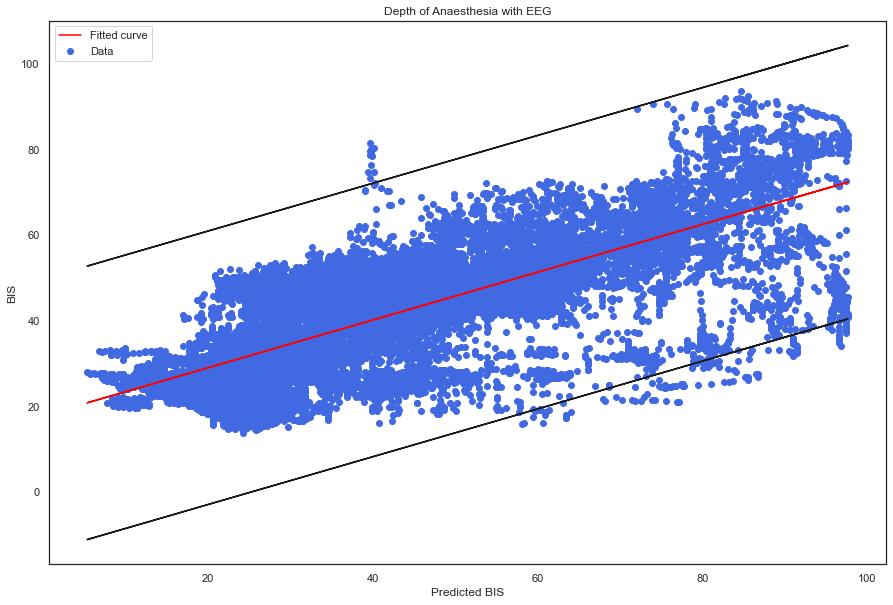

Metrics(r2=0.564963520363345, mse=158.41875678543192)

In [131]:
ransac = model('ransac', training_df)
ransac.fit(test_features_C)
ransac.predict(training_df, test_features_C, visualize_scatter=True)

<br/>

## Training performance: <code>Extreme Gradient Boosted Trees</code>

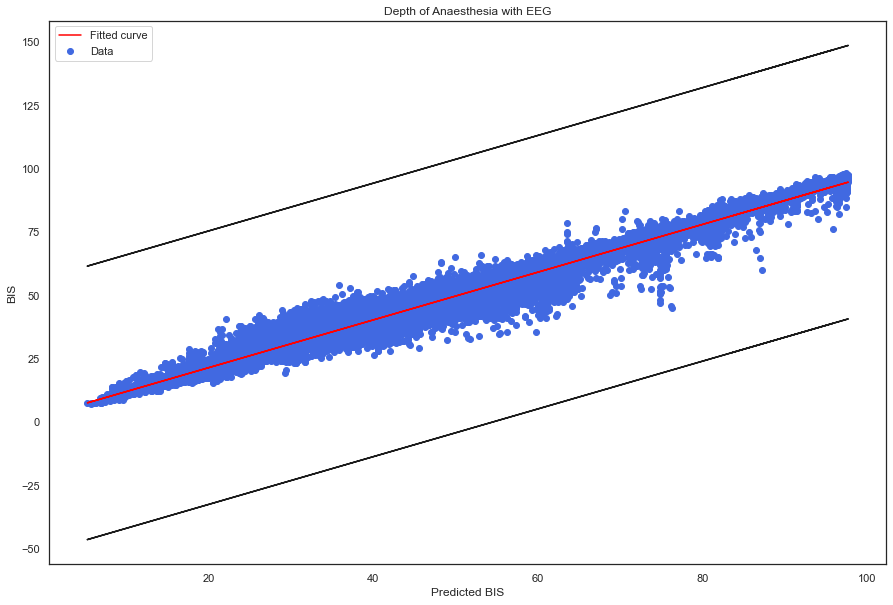

Metrics(r2=0.9673962581881452, mse=11.872669272933429)

In [119]:
xgb = model('xgboost', training_df)
xgb.fit(test_features_C)
xgb.predict(training_df, test_features_C, visualize_scatter=True)

<br/>

## Training performance: <code>Support Vector Regression</code>

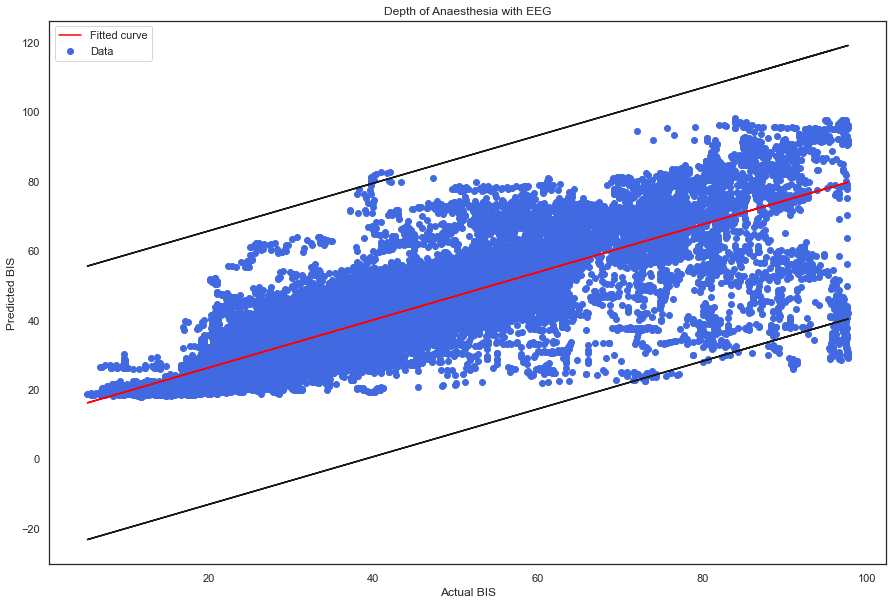

Metrics(r2=0.6581460949755171, mse=124.48627453370149)

In [13]:
svr = model('svr', training_df)
svr.fit(test_features_B)
svr.predict(training_df, test_features_B, visualize_scatter=True)

<br/>

## Training performance: <code>Histogram Gradient Boosting Regressor</code>

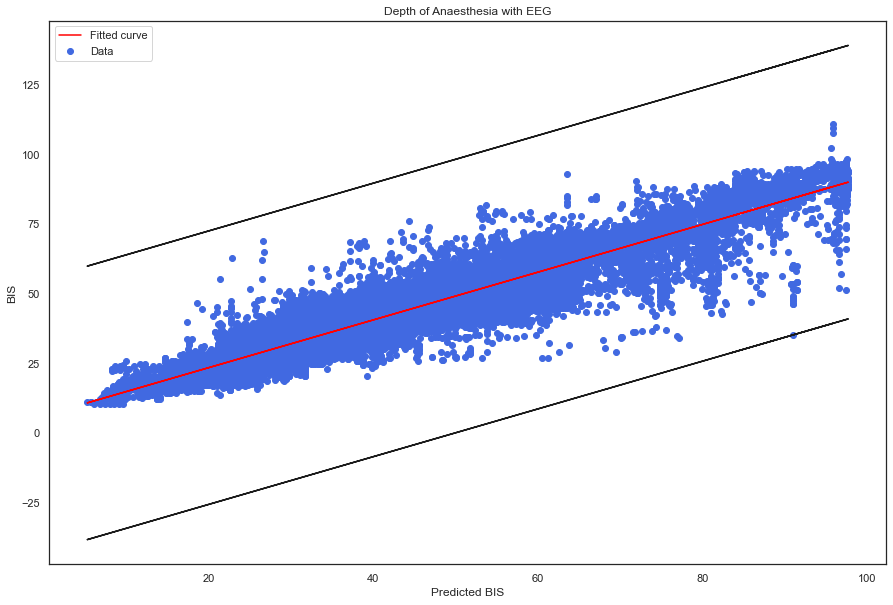

Metrics(r2=0.8885862024578396, mse=40.571391415529746)

In [121]:
hist = model('hist_r', training_df)
hist.fit(test_features_C)
hist.predict(training_df, test_features_C, visualize_scatter=True)

<br/>

Clearly, the XGB model is overfitting the data. I did not expect it to perform well on the test set, and it didn't :).

<br/>

<br/>

# TESTING

## Testing Model: <code>Support Vector Regression</code>

In [22]:
test_df = pd.read_csv('test_set.csv')

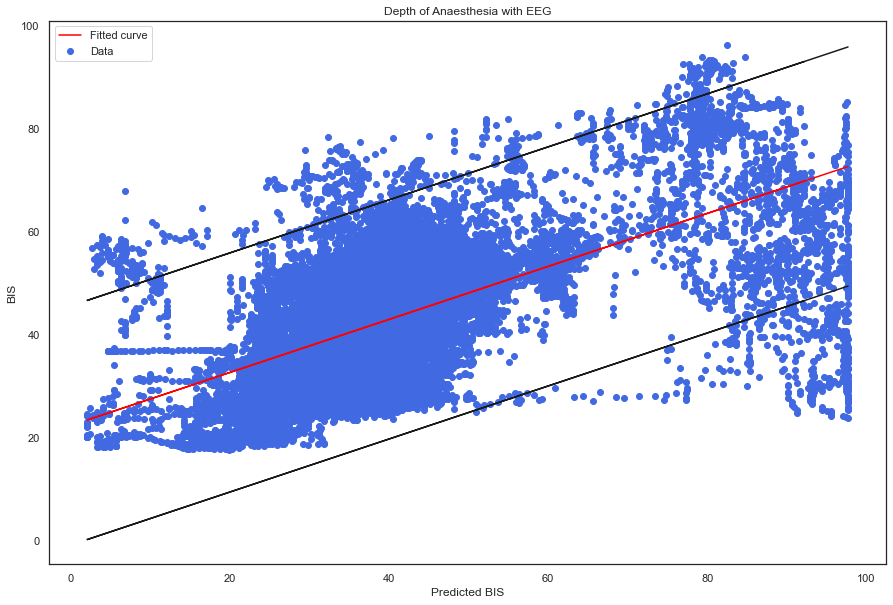

Metrics(r2=0.2555455382100157, mse=168.16365752580583)

In [23]:
# Using the testing data
svr.predict(test_df, test_features_B, visualize_scatter=True, save=True)

<br/>

<br/>

## Testing Model: <code>Histogram Gradient Boosting Regressor</code>

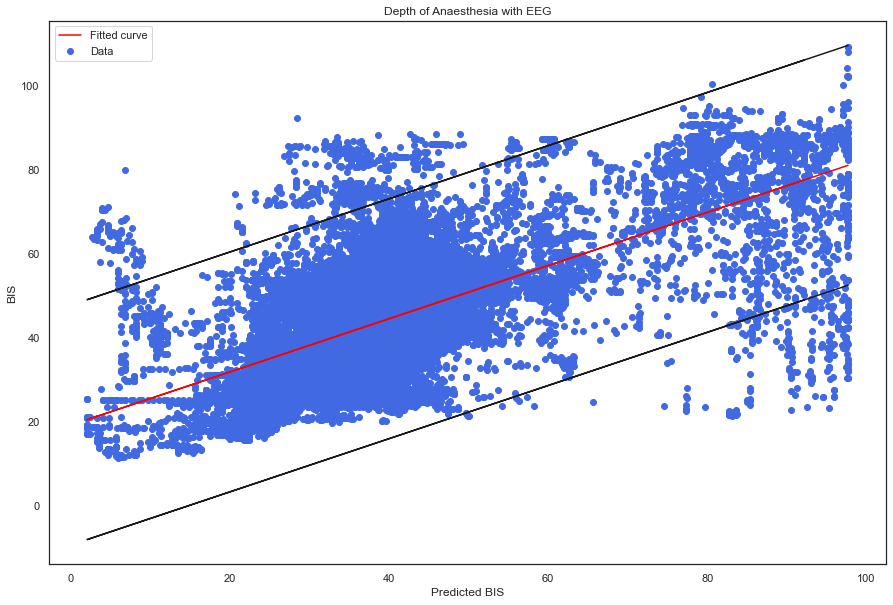

Metrics(r2=0.22532119665019634, mse=174.99098691112192)

In [123]:
hist.predict(test_df, test_features_C, visualize_scatter=True)

<br/>

## Testing Model: <code>Extreme Gradient Boosted trees</code>

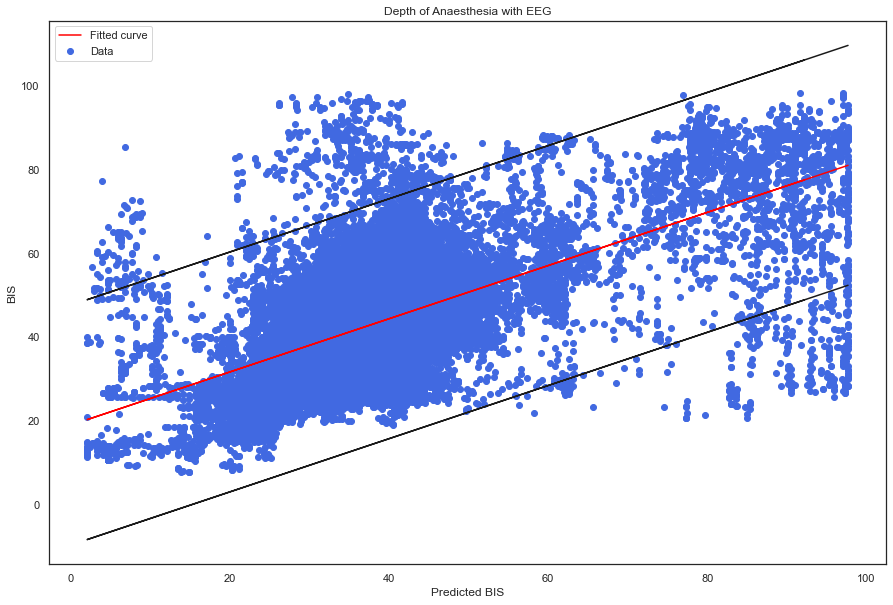

Metrics(r2=0.1673393079396418, mse=188.0884253392252)

In [124]:
xgb.predict(test_df, test_features_C, visualize_scatter=True)

<br/>

## Testing Model: <code>RANSAC</code>

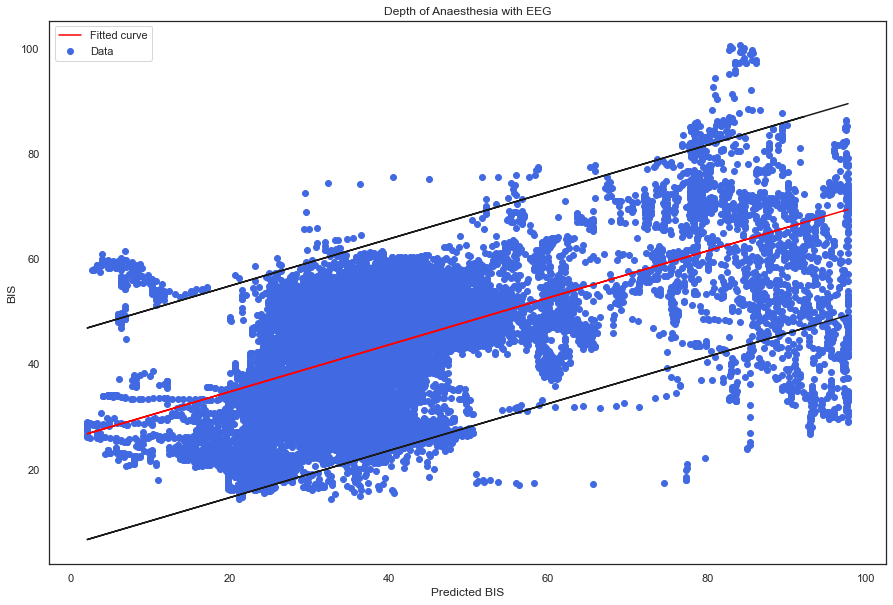

Metrics(r2=0.18651358014858332, mse=183.75717888890753)

In [125]:
ransac.predict(test_df, test_features_C, visualize_scatter=True)

<br/>

<br/>

# DoA prediction in test patients

In [97]:
test_data = [file for file in os.listdir("./Class B test sets") if ".mat" in file]

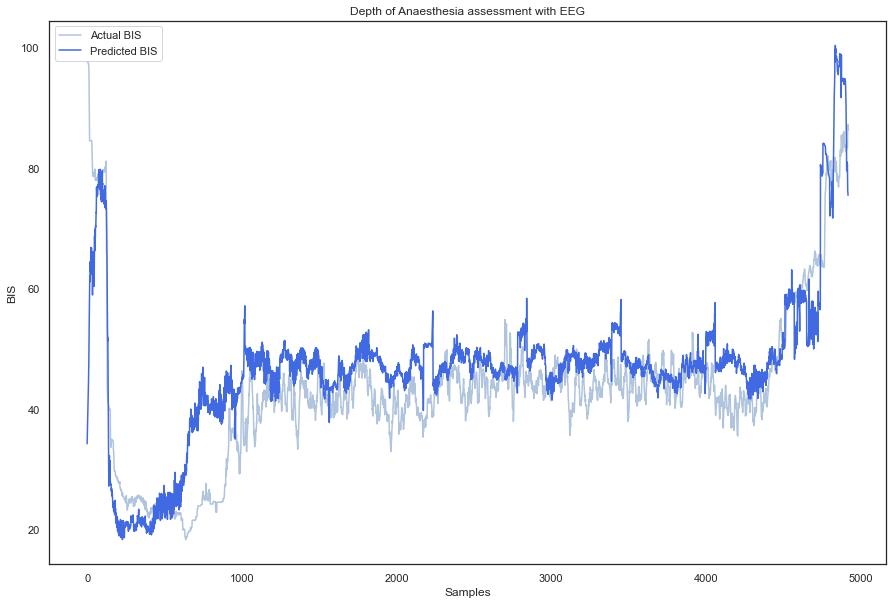

Metrics(r2=0.6335988257242031, mse=60.785810891626426)


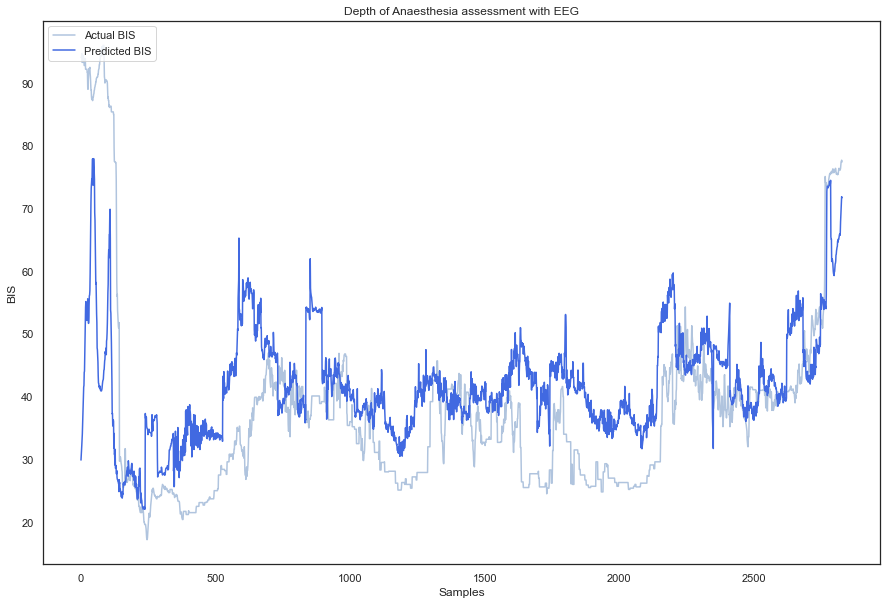

Metrics(r2=0.2432142553401443, mse=173.0580893375456)


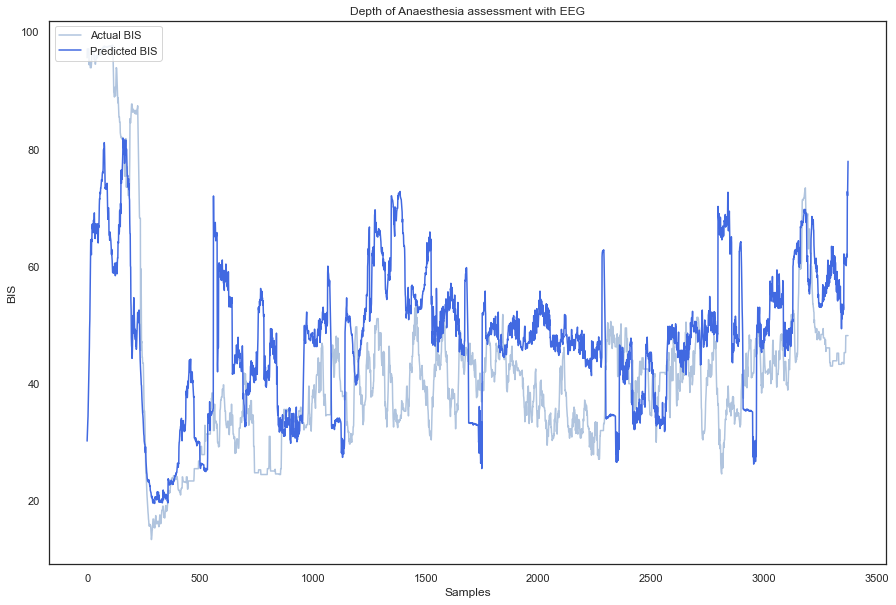

Metrics(r2=0.04522697433103784, mse=237.64320073897673)


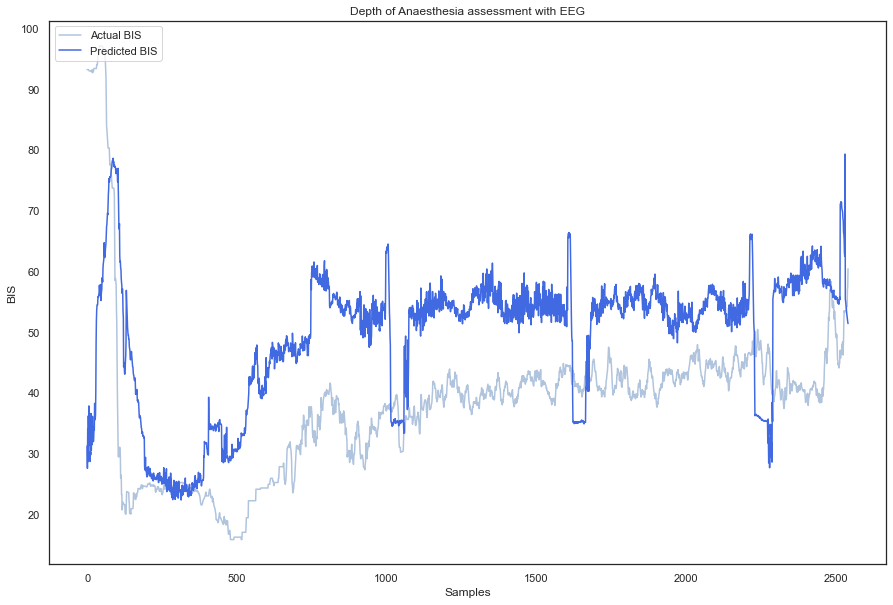

Metrics(r2=-0.6081535624710468, mse=278.7062261169298)


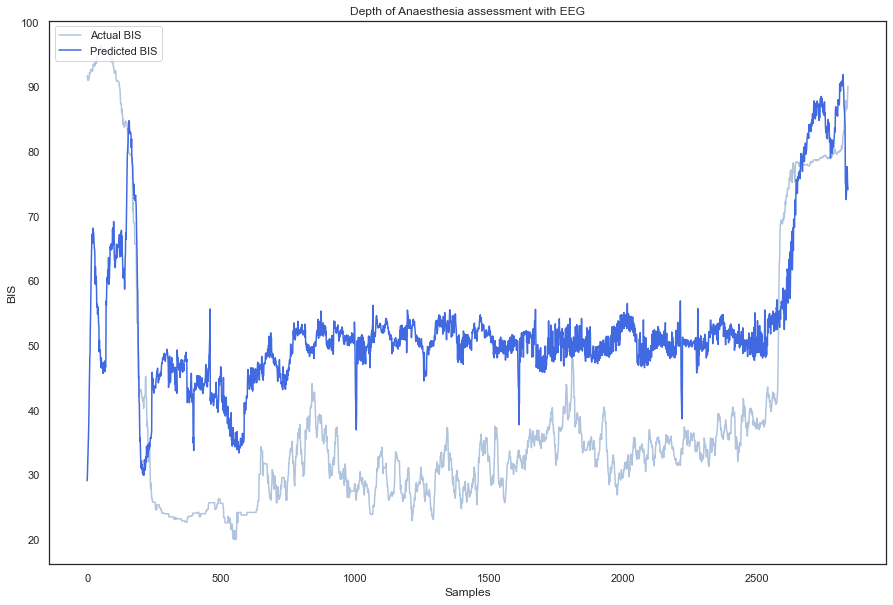

Metrics(r2=0.05733937814871115, mse=354.10625085557)


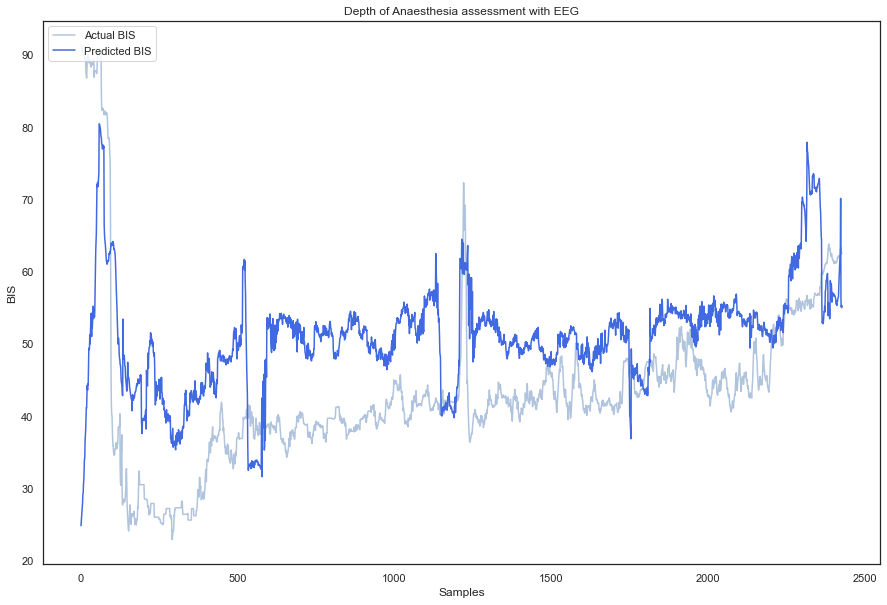

Metrics(r2=-0.20160276798904242, mse=162.23171356686248)


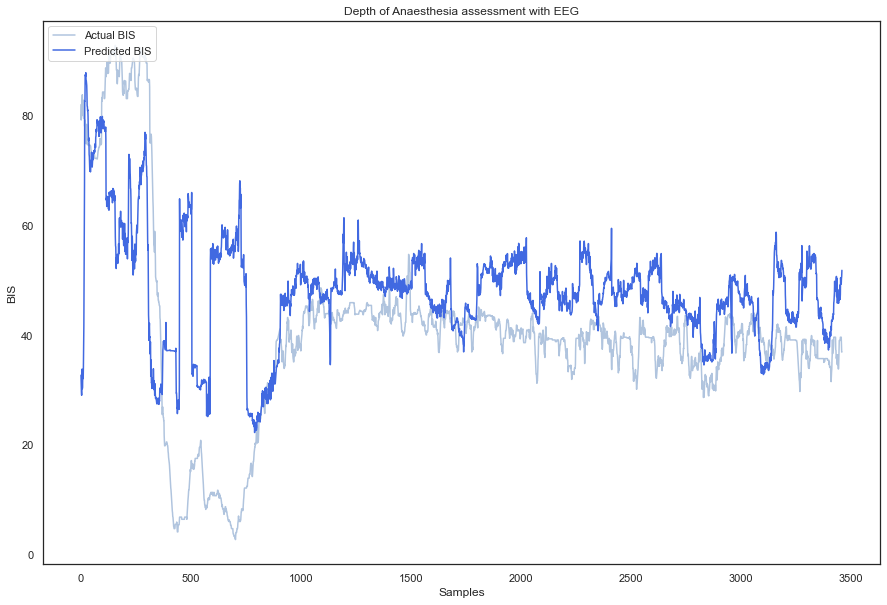

Metrics(r2=0.01870091827172049, mse=300.87175641420805)


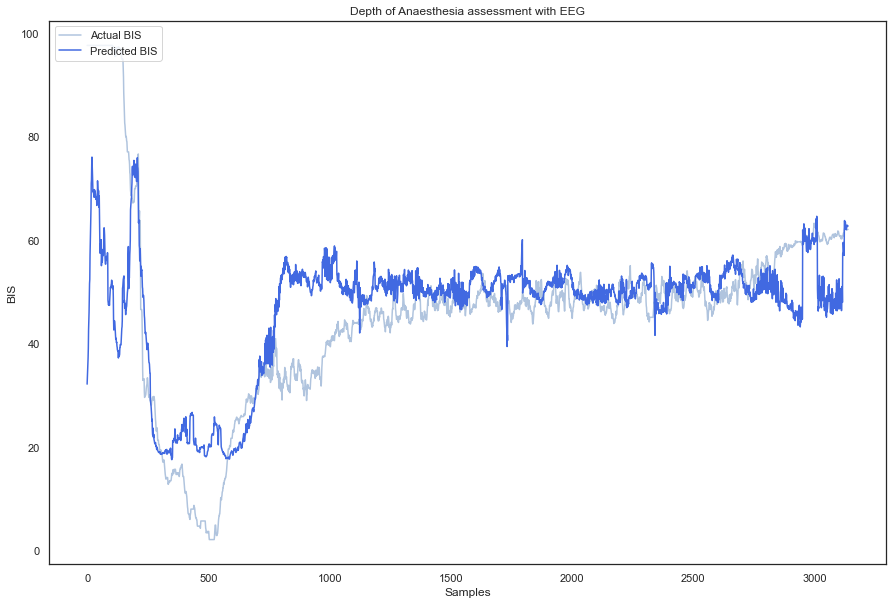

Metrics(r2=0.477962093083277, mse=170.21884696696705)


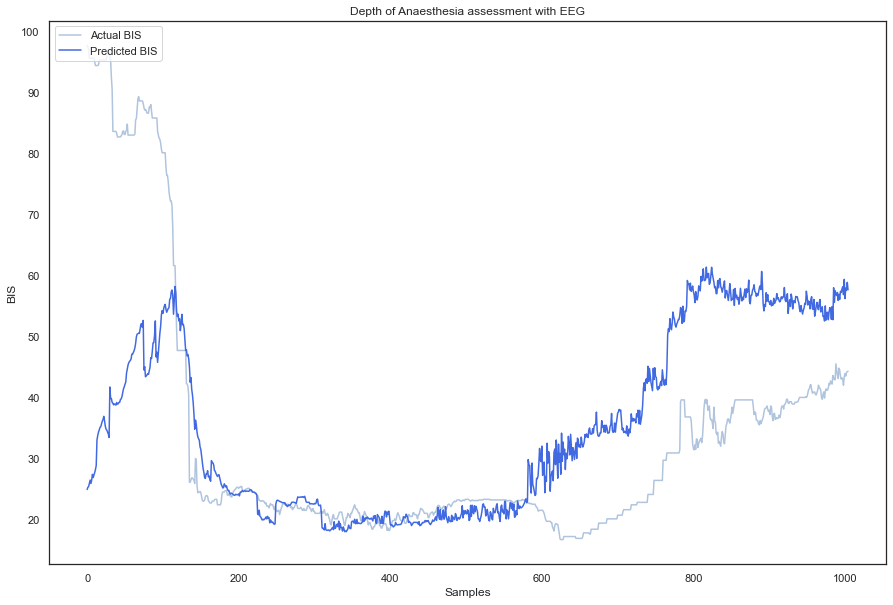

Metrics(r2=0.1486701224788649, mse=366.7097908099181)


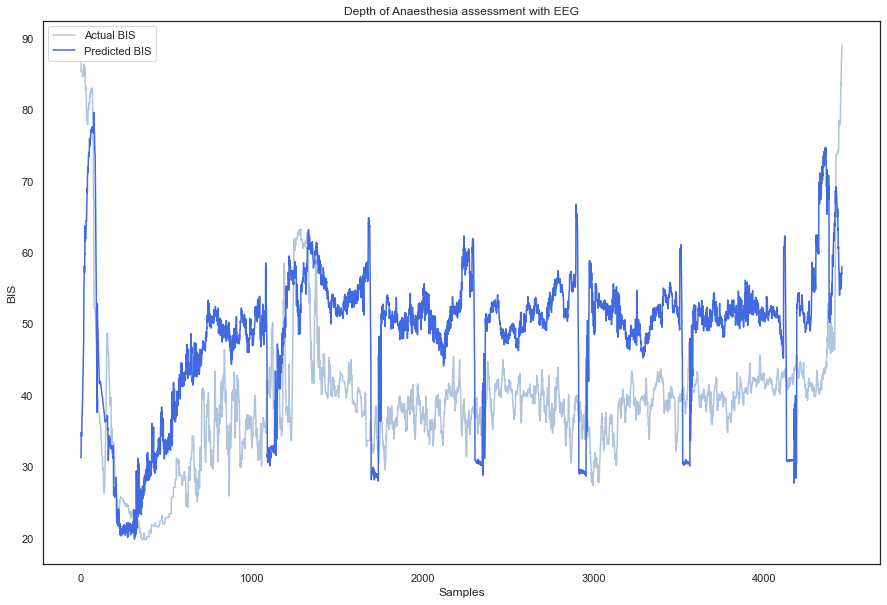

Metrics(r2=-0.9525837230037306, mse=181.31010596581385)


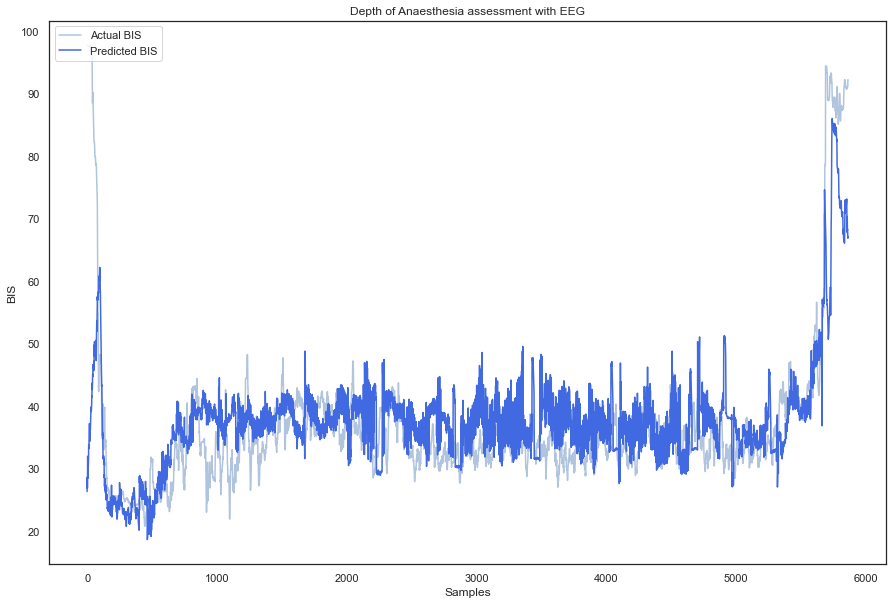

Metrics(r2=0.5086077195216812, mse=76.4805735654369)


In [140]:
for test in test_data:
    patient = create_dataset(data_dir="test", patient=test)
    metrics = svr.predict(patient, test_features_A, visualize_line=True)
    print(metrics)

<br/>